In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point

In [ ]:
def map_lat_long_to_nta(coordinates_df, nta_shapefile_path):
    """
    Maps latitude and longitude coordinates to NYC NTA geodata.

    Args:
        coordinates_df (pd.DataFrame): DataFrame with 'latitude' and 'longitude' columns.
        nta_shapefile_path (str): Path to the NTA shapefile (.shp).

    Returns:
        pd.DataFrame: Original DataFrame with a new 'NTA_Name' column.
    """
    # 1. Load the NTA shapefile into a GeoDataFrame
    # Ensure the path points to your downloaded .shp file
    nta_gdf = gpd.read_file(nta_shapefile_path)

    # Reproject to WGS 84 (EPSG:4326) if necessary, which is standard for lat/long
    nta_gdf = nta_gdf.to_crs(epsg=4326)

    # 2. Convert the input coordinates DataFrame to a GeoDataFrame
    # Create Point objects from latitude and longitude columns
    geometry = [Point(xy) for xy in zip(coordinates_df['Longitude'], coordinates_df['Latitude'])]
    points_gdf = gpd.GeoDataFrame(coordinates_df, geometry=geometry, crs="EPSG:4326")

    # 3. Perform the spatial join
    # 'predicate="within"' joins points that fall inside the NTA polygons
    joined_data = gpd.sjoin(points_gdf, nta_gdf, how="left", predicate="within")

    # 4. Extract the relevant NTA name column (usually 'NTAName' or similar)
    # The exact column name might vary by the shapefile version
    # 'NTAName' is a common column for the human-readable neighborhood name
    if 'NTAName' in joined_data.columns:
        coordinates_df['NTA_Name'] = joined_data['NTAName']
    elif 'name' in joined_data.columns:
         coordinates_df['NTA_Name'] = joined_data['name']
    else:
        print("Could not find a standard NTA name column. Check shapefile attributes.")
        # You can return other relevant ID columns like 'NTACode' as needed

    return coordinates_df


In [ ]:
# Path to NTA shapefile
shapefile_path = 'https://raw.githubusercontent.com/jung8027/DataSciProject/main/DATA/GIS/NY-NTA2020_25/nynta2020.shp'

Poverty Choropleth

In [ ]:
# Poverty data
pov_data = pd.read_csv('https://raw.githubusercontent.com/jung8027/DataSciProject/refs/heads/main/DATA/CLEANED/pov_data%5Bcleaned%5D.csv')

# Load the NTA shapefile into a GeoDataFrame
gdf_nta = gpd.read_file(shapefile_path)

# Merge poverty data with the NTA GeoDataFrame using NTA names
merged_pov_data = gdf_nta.merge(pov_data, left_on='NTAName', right_on='NTA_NAME', how='left')

# Display the first few rows of the merged data
print("Merged Poverty Data with NTA GeoDataFrame:")
display(merged_pov_data.head())

Merged Poverty Data with NTA GeoDataFrame:


,BoroCode,BoroName,CountyFIPS,NTA2020,NTAName,NTAAbbrev,NTAType,CDTA2020,CDTAName,Shape_Leng,Shape_Area,geometry,NTA_CODE,NTA_NAME,Households_Below_Poverty,Poverty_percent
0,3,Brooklyn,047,BK0101,Greenpoint,Grnpt,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28919.561151,3.532181e+07,"POLYGON ((1003059.997 204572.025, 1002991.367 ...",470101.0,Greenpoint,"3,480",9.3
1,3,Brooklyn,047,BK0101,Greenpoint,Grnpt,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28919.561151,3.532181e+07,"POLYGON ((1003059.997 204572.025, 1002991.367 ...",201.0,Greenpoint,"18,006",17.1
2,3,Brooklyn,047,BK0102,Williamsburg,Wllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28134.082661,2.885285e+07,"POLYGON ((995851.916 203199.332, 995969.193 20...",470102.0,Williamsburg,"9,962",15.8
3,3,Brooklyn,047,BK0103,South Williamsburg,SWllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),18250.280091,1.520896e+07,"POLYGON ((998047.21 196303.325, 998157.901 196...",470103.0,South Williamsburg,"23,599",50.3
4,3,Brooklyn,047,BK0104,East Williamsburg,EWllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),43184.800376,5.226741e+07,"POLYGON ((1005302.497 199455.73, 1005307.792 1...",470104.0,East Williamsburg,"13,537",25.4


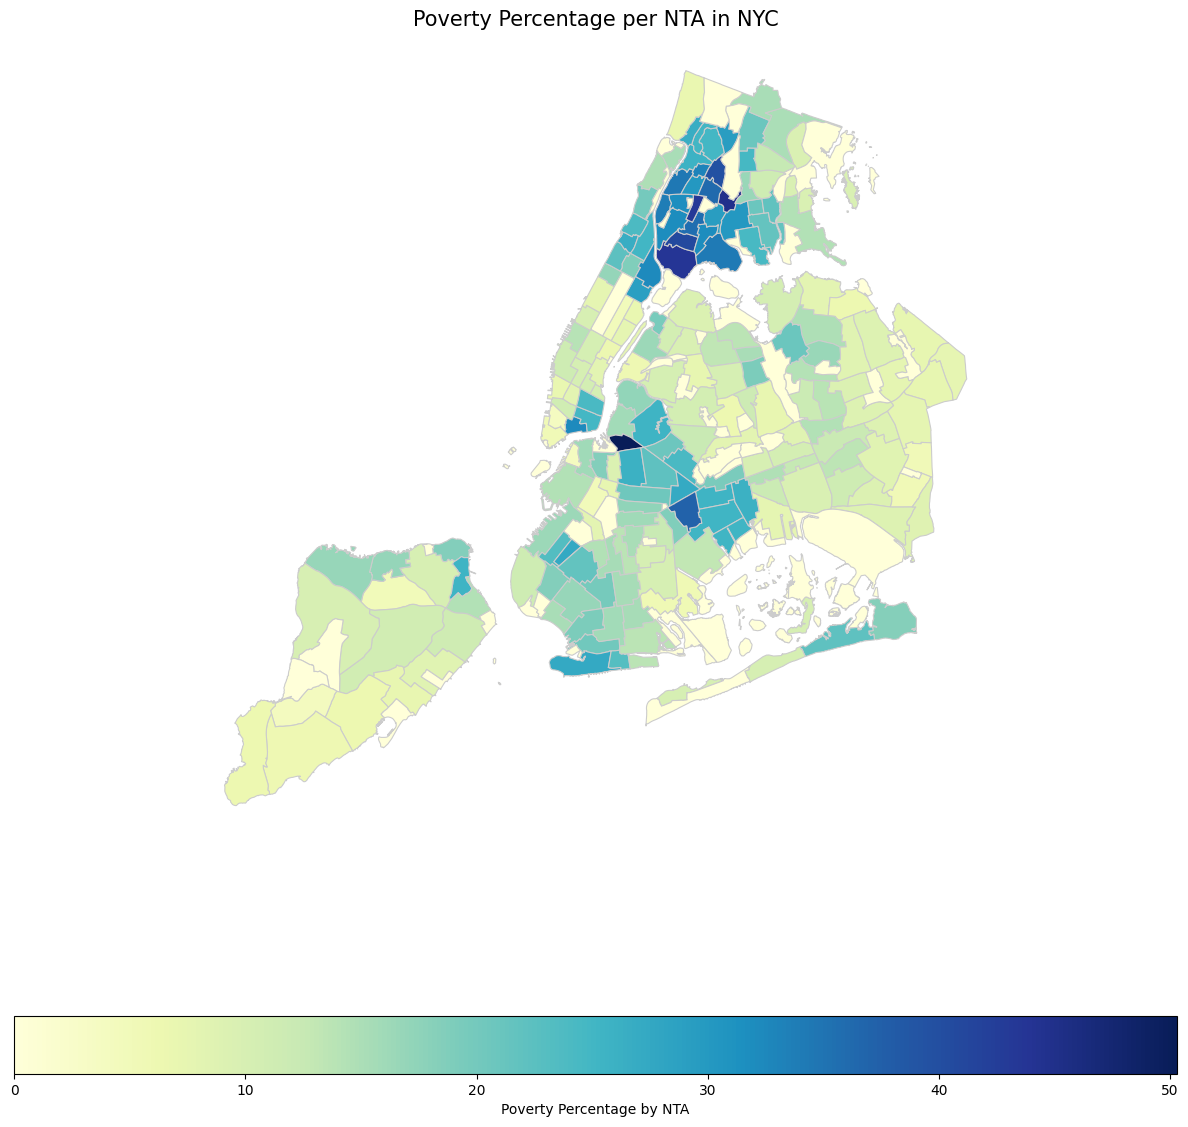

In [ ]:
# Fill NaN values in Poverty_percent with 0, assuming missing data means 0% poverty for visualization purposes
merged_pov_data['Poverty_percent'] = merged_pov_data['Poverty_percent'].fillna(0)

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
merged_pov_data.plot(
    column='Poverty_percent',
    cmap='YlGnBu', # Yellow-Green-Blue color scheme for poverty percentage
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label': "Poverty Percentage by NTA", 'orientation': "horizontal"}
)

ax.set_title('Poverty Percentage per NTA in NYC', fontsize=15)
ax.set_axis_off() # Turn off the axis
plt.show()

AQE Choropleth

In [ ]:
# AQE data
AQE_data = pd.read_csv('https://raw.githubusercontent.com/jung8027/DataSciProject/refs/heads/main/DATA/CLEANED/aqe_data%5Bcleaned%5D.csv')

# Load the NTA shapefile into a GeoDataFrame
gdf_nta = gpd.read_file(shapefile_path)

# Ensure 'NTACODE' in AQE_data is of string type for merging
AQE_data['NTACODE'] = AQE_data['NTACODE'].astype(str)

# Merge AQE data with the NTA GeoDataFrame
merged_aqe_data = gdf_nta.merge(AQE_data, left_on='NTA2020', right_on='NTACODE', how='left')

# Display the first few rows of the merged data
print("Merged AQE Data with NTA GeoDataFrame:")
display(merged_aqe_data.head())

Merged AQE Data with NTA GeoDataFrame:


,BoroCode,BoroName,CountyFIPS,NTA2020,NTAName,NTAAbbrev,NTAType,CDTA2020,CDTAName,Shape_Leng,...,NTACODE,NTA_NAME,PM_Avg,PM_tertiles,NO2_Avg,NO2_tertiles,cook_tertiles,Building_emissions,Industrial_tertiles,Traffic_tertiles
0,3,Brooklyn,047,BK0101,Greenpoint,Grnpt,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28919.561151,...,BK0101,Greenpoint,7.650541,High,20.283217,High,High,Medium,High,Low
1,3,Brooklyn,047,BK0102,Williamsburg,Wllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28134.082661,...,BK0102,Williamsburg,6.696599,High,15.296605,High,High,High,High,High
2,3,Brooklyn,047,BK0103,South Williamsburg,SWllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),18250.280091,...,BK0103,South Williamsburg,6.740377,High,17.234508,High,Low,High,High,High
3,3,Brooklyn,047,BK0104,East Williamsburg,EWllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),43184.800376,...,BK0104,East Williamsburg,7.128230,High,18.022384,High,High,High,High,High
4,3,Brooklyn,047,BK0201,Brooklyn Heights,BkHts,0,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,14312.192285,...,BK0201,Brooklyn Heights,7.019150,High,19.815623,High,High,High,Low,High


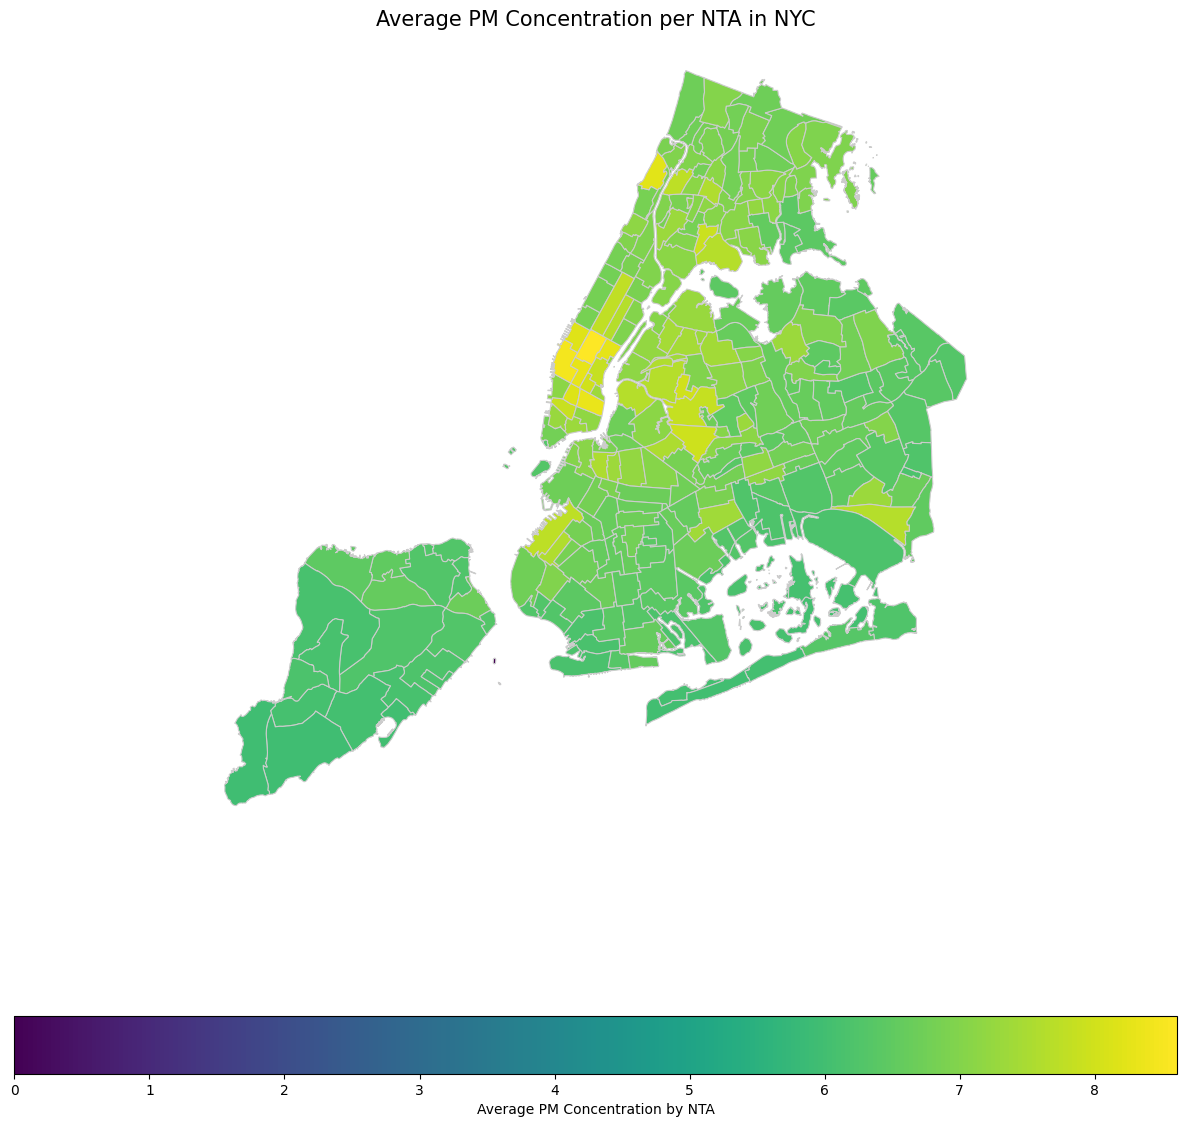

In [ ]:
# Fill NaN values in PM_Avg with 0, assuming missing data means 0 PM for visualization purposes
merged_aqe_data['PM_Avg'] = merged_aqe_data['PM_Avg'].fillna(0)

# Plot the choropleth map for PM_Avg
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
merged_aqe_data.plot(
    column='PM_Avg',
    cmap='viridis', # A perceptually uniform colormap
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label': "Average PM Concentration by NTA", 'orientation': "horizontal"}
)

ax.set_title('Average PM Concentration per NTA in NYC', fontsize=15)
ax.set_axis_off() # Turn off the axis
plt.show()

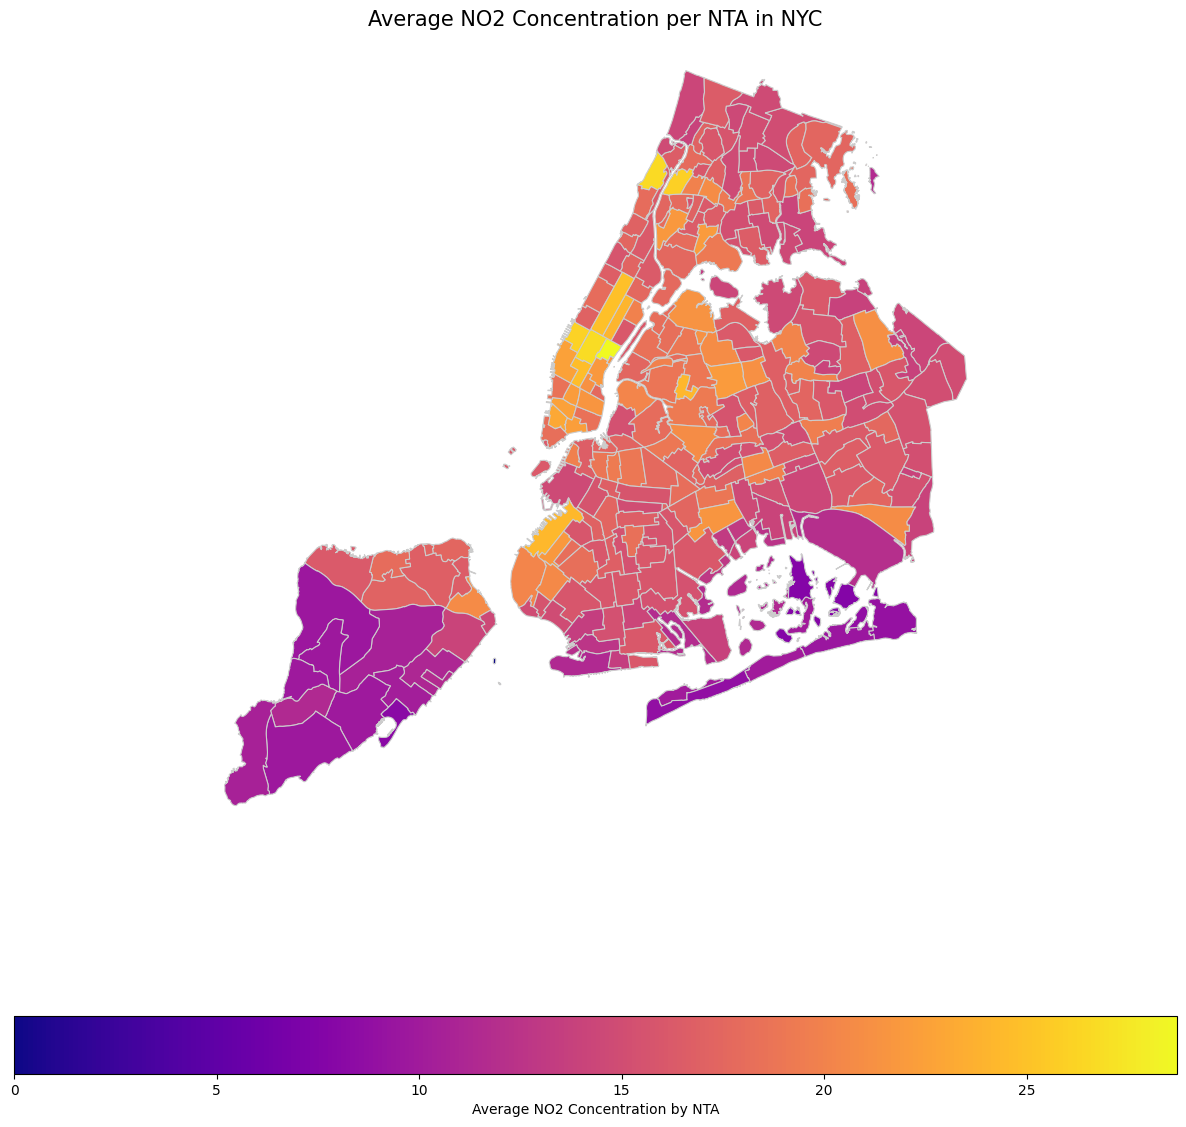

In [ ]:
# Fill NaN values in NO2_Avg with 0, assuming missing data means 0 NO2 for visualization purposes
merged_aqe_data['NO2_Avg'] = merged_aqe_data['NO2_Avg'].fillna(0)

# Plot the choropleth map for NO2_Avg
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
merged_aqe_data.plot(
    column='NO2_Avg',
    cmap='plasma', # A perceptually uniform colormap suitable for NO2 levels
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label': "Average NO2 Concentration by NTA", 'orientation': "horizontal"}
)

ax.set_title('Average NO2 Concentration per NTA in NYC', fontsize=15)
ax.set_axis_off() # Turn off the axis
plt.show()

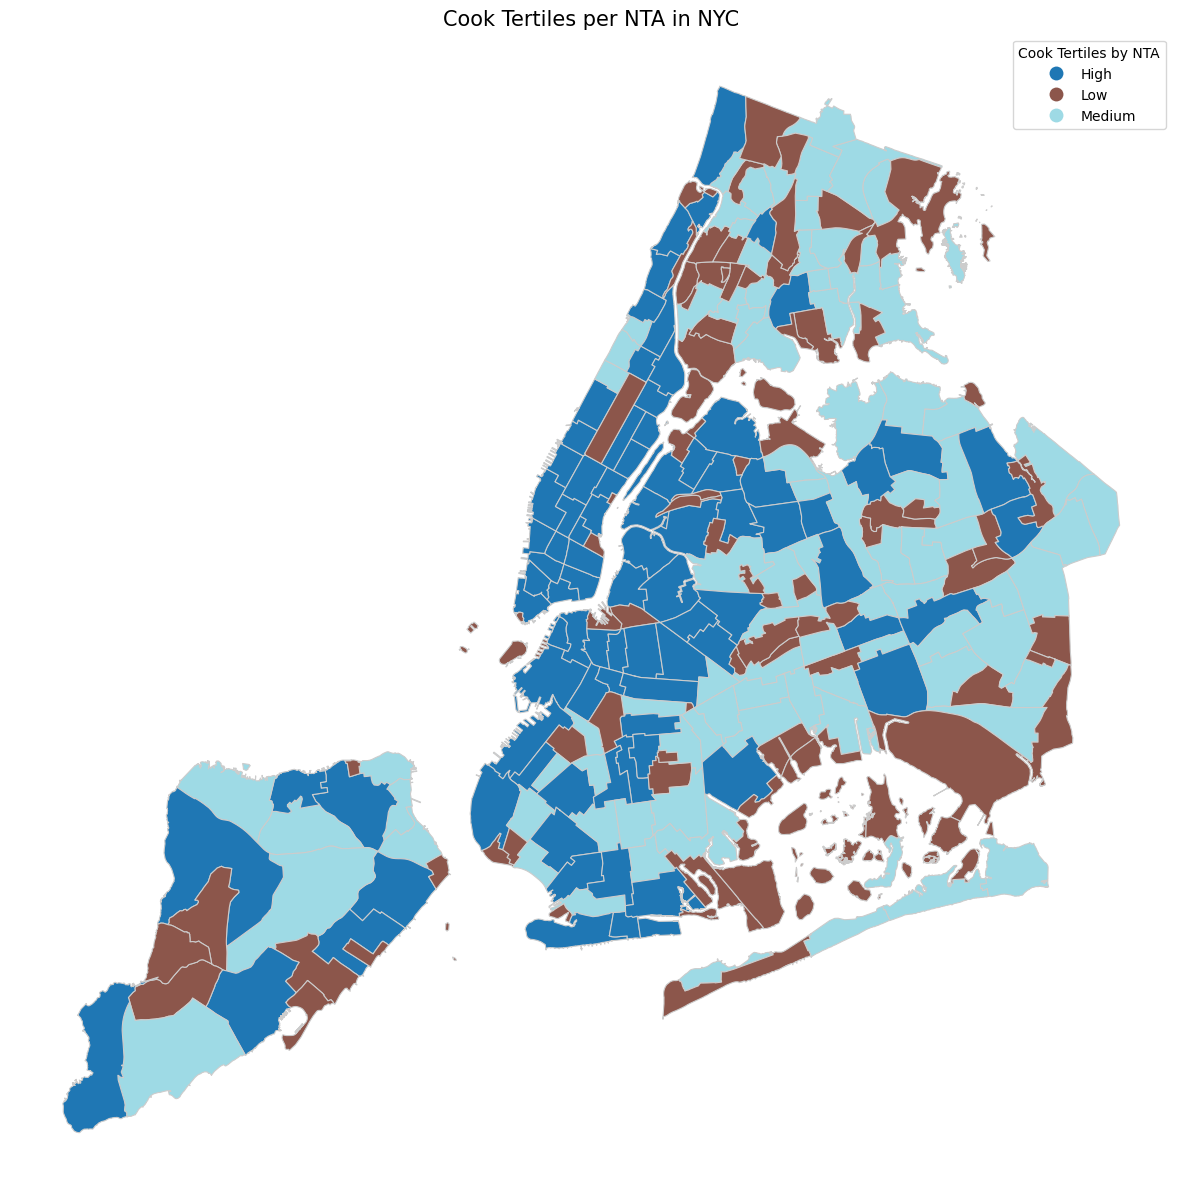

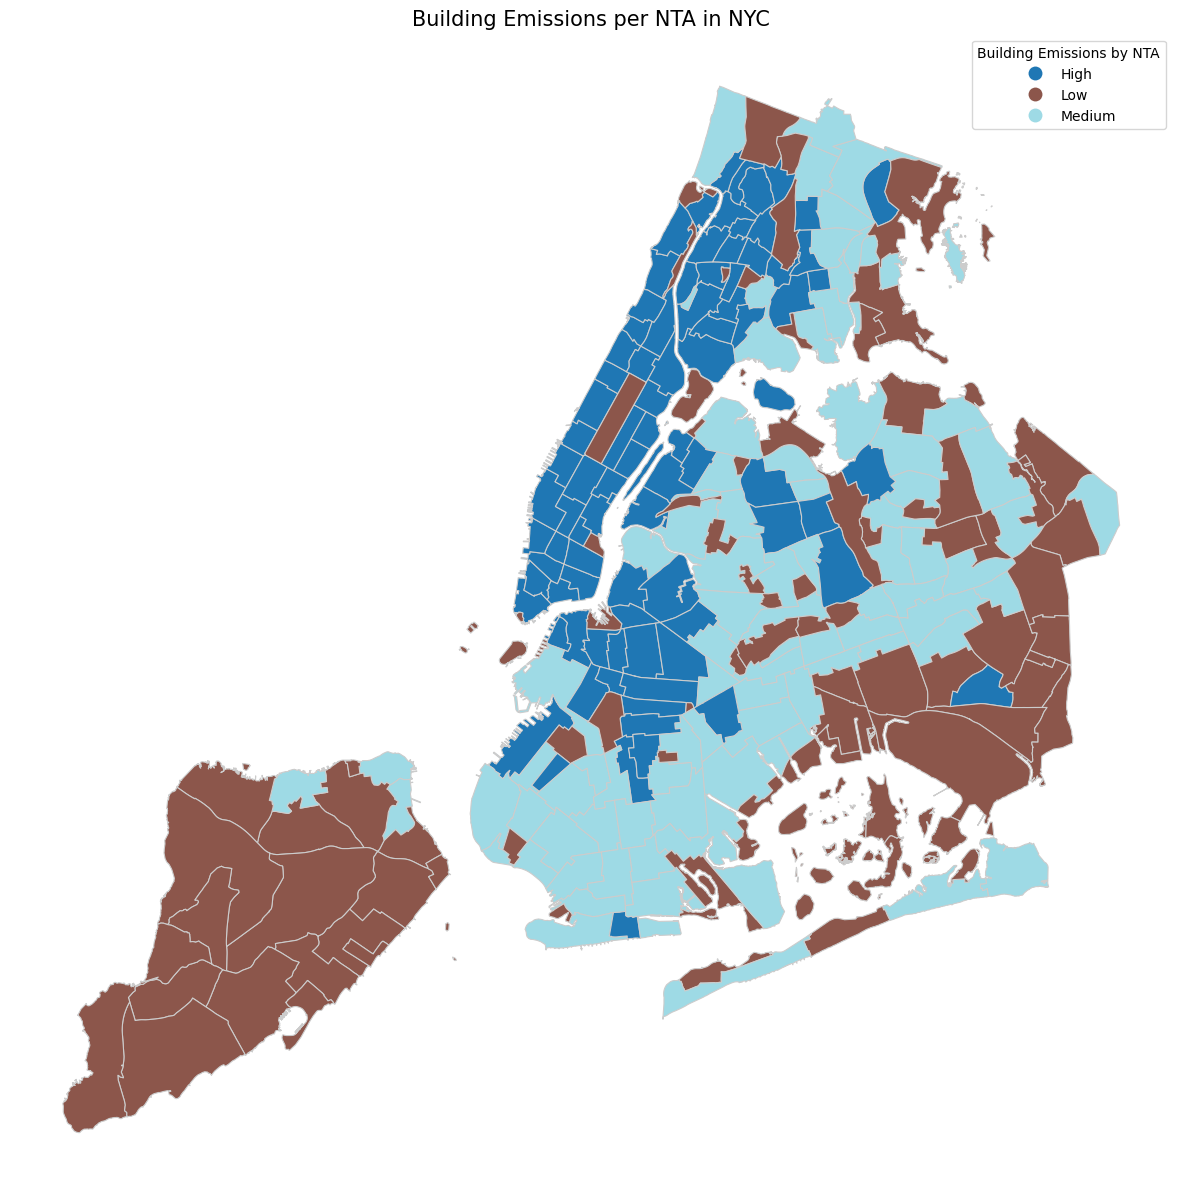

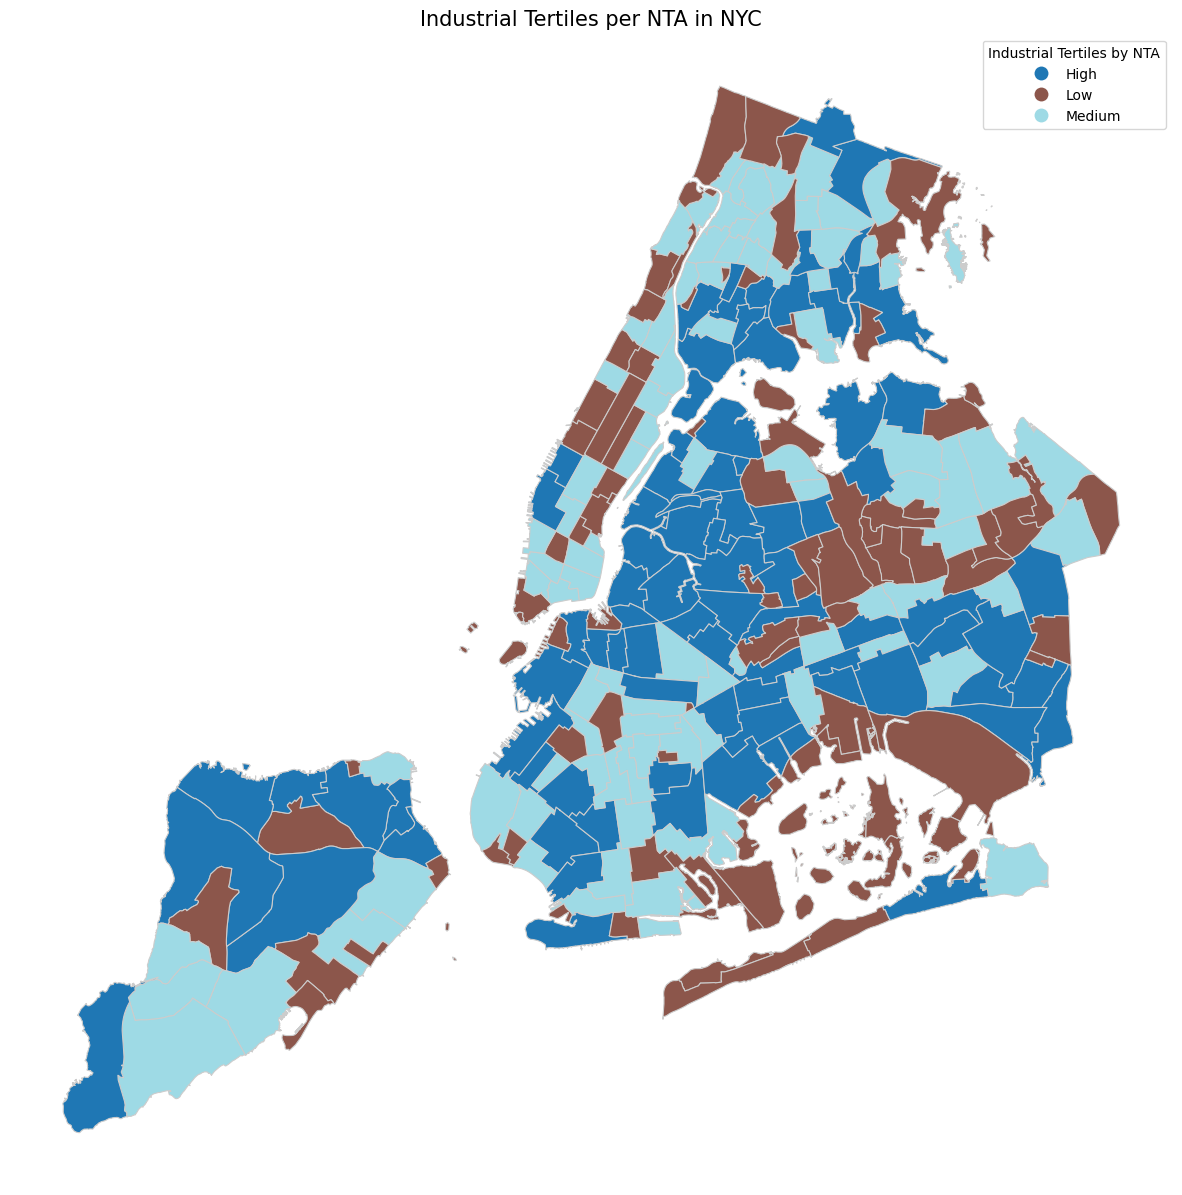

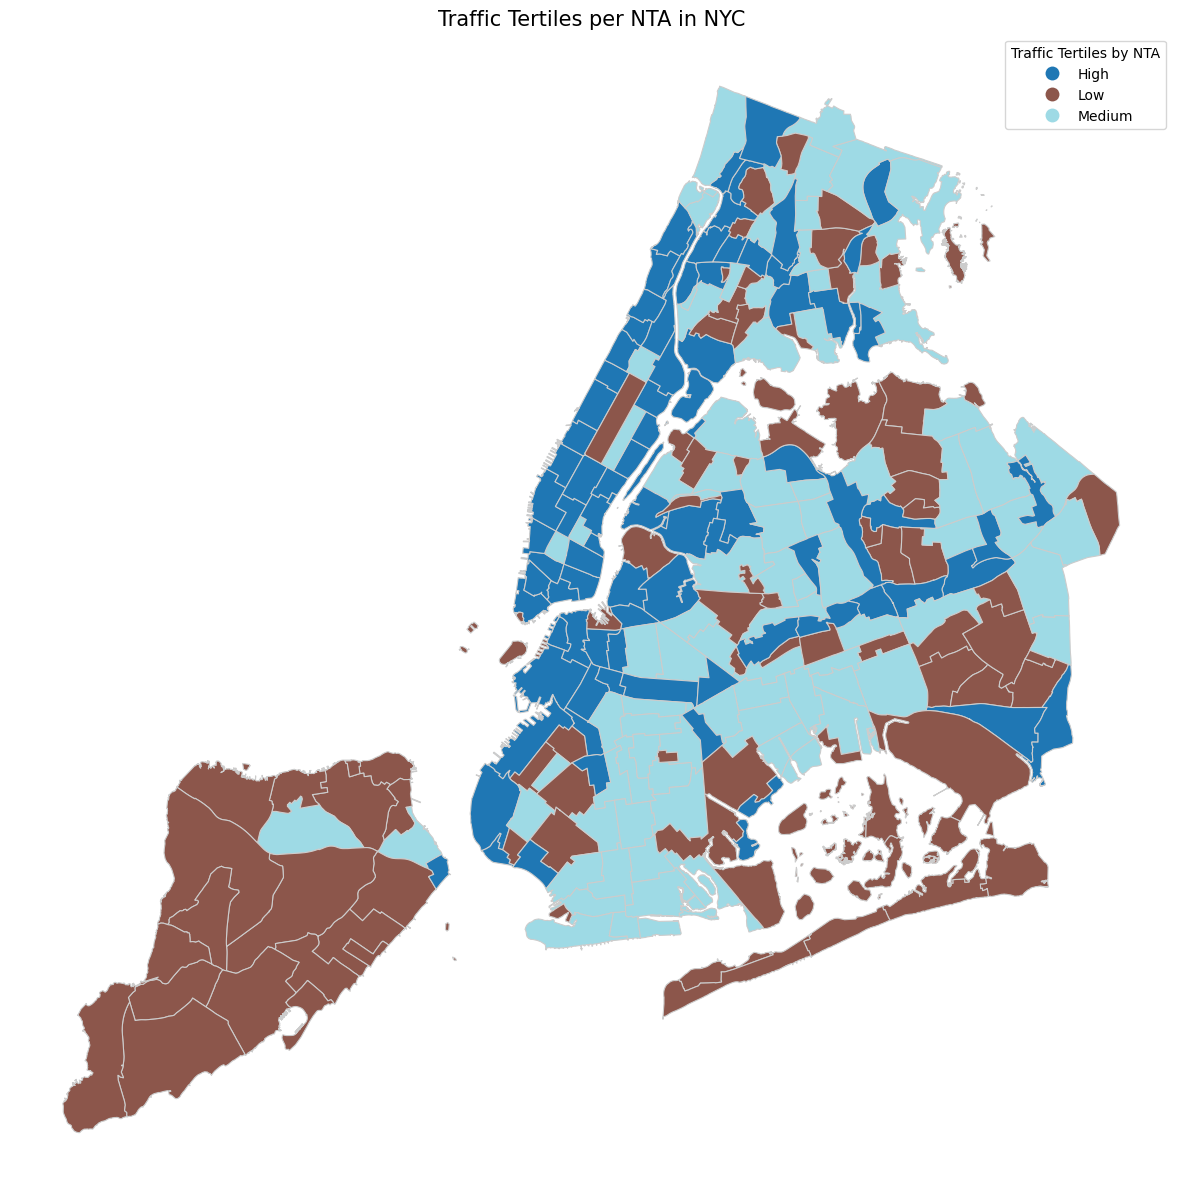

In [ ]:
columns_to_visualize = ['cook_tertiles', 'Building_emissions', 'Industrial_tertiles', 'Traffic_tertiles']

for col in columns_to_visualize:
    # Fill NaN values with 'Unknown' for categorical columns to ensure all NTAs are plotted
    merged_aqe_data[col] = merged_aqe_data[col].fillna('Unknown')

    fig, ax = plt.subplots(1, 1, figsize=(15, 15))

    # Plot the choropleth map
    merged_aqe_data.plot(
        column=col,
        cmap='tab20', # 'tab20' is a good qualitative colormap for categorical data
        linewidth=0.8,
        ax=ax,
        edgecolor='0.8',
        legend=True,
        categorical=True, # Explicitly tell geopandas that the column is categorical
        legend_kwds={'title': f"{col.replace('_', ' ').title()} by NTA"} # Removed 'orientation'
    )

    ax.set_title(f'{col.replace("_", " ").title()} per NTA in NYC', fontsize=15)
    ax.set_axis_off() # Turn off the axis
    plt.show()

Mold Choropleth

In [ ]:
# Mold data
mold_data = pd.read_csv('https://raw.githubusercontent.com/jung8027/DataSciProject/refs/heads/main/DATA/CLEANED/2010-present_mold_data_location%5Bcleaned%5D.csv')

# Map the coordinates
df_with_nta = map_lat_long_to_nta(mold_data, shapefile_path)

# Print the result
print(df_with_nta[['Borough', 'NTA_Name']])

            Borough                                           NTA_Name
0         MANHATTAN                               Midtown-Times Square
1          BROOKLYN                              Coney Island-Sea Gate
2            QUEENS  Breezy Point-Belle Harbor-Rockaway Park-Broad ...
3     STATEN ISLAND                            Great Kills-Eltingville
4         MANHATTAN                               Midtown-Times Square
...             ...                                                ...
5231       BROOKLYN                Downtown Brooklyn-DUMBO-Boerum Hill
5232          BRONX                                         Mount Hope
5233      MANHATTAN        Upper East Side-Lenox Hill-Roosevelt Island
5234      MANHATTAN        Upper East Side-Lenox Hill-Roosevelt Island
5235      MANHATTAN                                           Gramercy

[5236 rows x 2 columns]


In [ ]:
nta_incident_counts = df_with_nta['NTA_Name'].value_counts().reset_index()
nta_incident_counts.columns = ['NTA_Name', 'Incident_Count']

print("Mold Incident Counts per NTA:")
display(nta_incident_counts.head())

Mold Incident Counts per NTA:


,NTA_Name,Incident_Count
0,Midtown-Times Square,191
1,Midtown South-Flatiron-Union Square,135
2,Chelsea-Hudson Yards,105
3,New Dorp-Midland Beach,86
4,Sheepshead Bay-Manhattan Beach-Gerritsen Beach,84


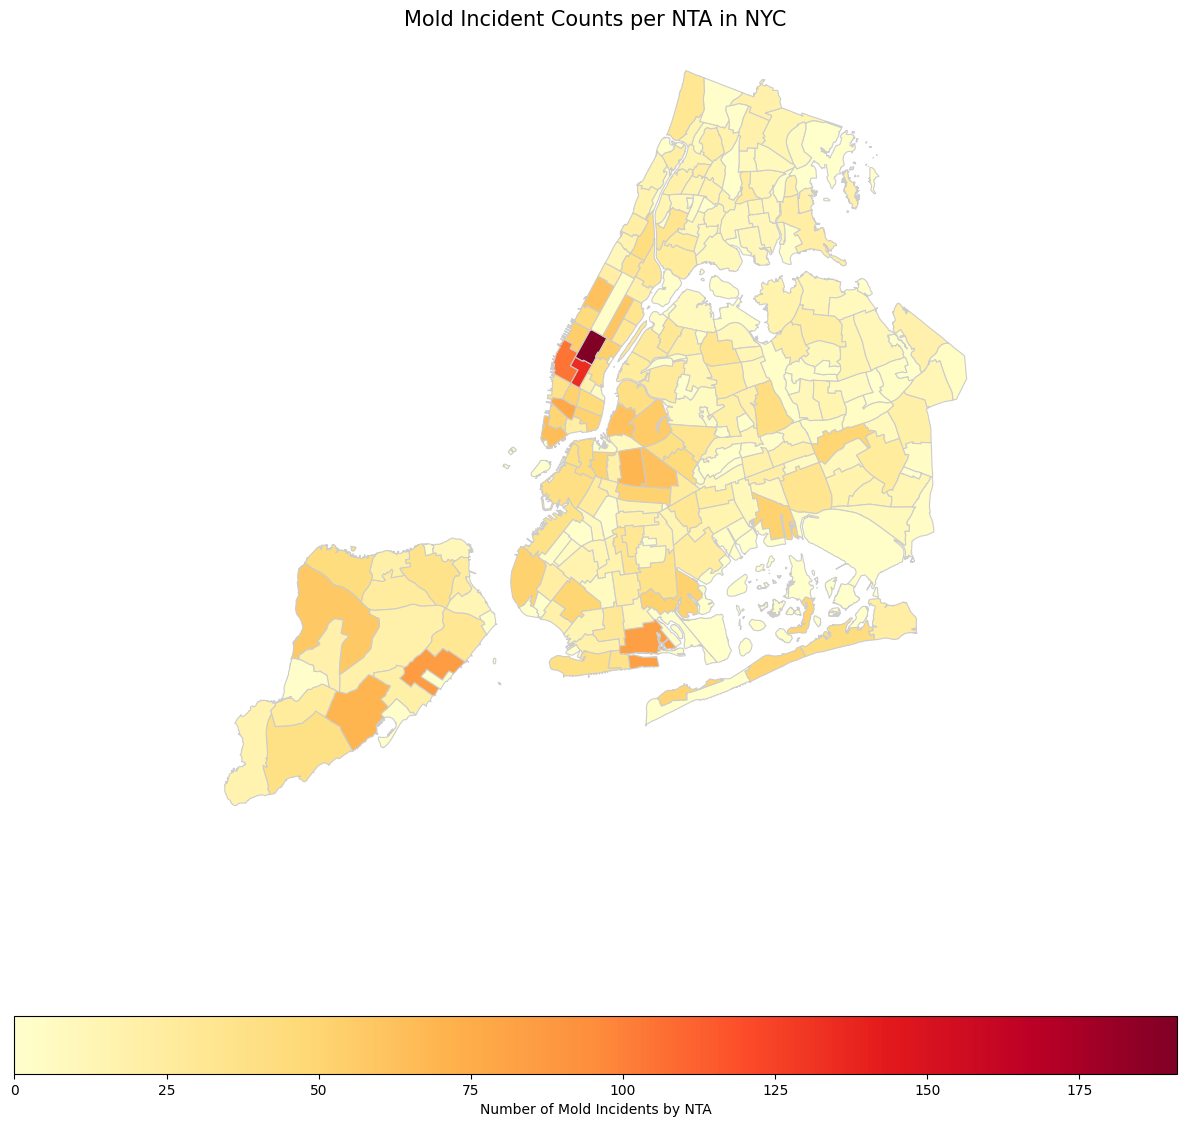

In [ ]:
# Merge the NTA incident counts with the NTA GeoDataFrame
gdf_nta_incidents = gdf_nta.merge(nta_incident_counts, left_on='NTAName', right_on='NTA_Name', how='left')

# Fill NaN values in Incident_Count with 0, as these NTAs had no reported incidents
gdf_nta_incidents['Incident_Count'] = gdf_nta_incidents['Incident_Count'].fillna(0)

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
gdf_nta_incidents.plot(
    column='Incident_Count',
    cmap='YlOrRd', # Yellow-Orange-Red color scheme for incident counts
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label': "Number of Mold Incidents by NTA", 'orientation': "horizontal"}
)

ax.set_title('Mold Incident Counts per NTA in NYC', fontsize=15)
ax.set_axis_off() # Turn off the axis
plt.show()

In [ ]:
asthma_url = 'https://raw.githubusercontent.com/jung8027/DataSciProject/refs/heads/main/DATA/CLEANED/FINAL_MERGED_DATASET.csv'
shape_data_UHF = 'https://github.com/jung8027/DataSciProject/raw/refs/heads/main/DATA/GIS/UHF34-GIS/UHF_34_DOHMH.shp'

asthma_data_df = pd.read_csv(asthma_url)
print("First few rows of the asthma data:")
display(asthma_data_df.head())

First few rows of the asthma data:


,year,uhf_code,neighborhood,mold_complaints,PM_Avg,NO2_Avg,PM_tertiles,NO2_tertiles,cook_tertiles,Building_emissions,...,estimated_adults_with_asthma,age_adjusted_ed_rate_per_10k,estimated_annual_ed_visits,ed_rate_per_10k_age_0_4,estimated_annual_ed_visits_age_0_4,ed_rate_per_10k_age_5_17,estimated_annual_ed_visits_age_5_17,poverty_rate,households_below_poverty,statistically_significant
0,2020,404406,Bayside Little Neck-Fresh Meadows,0,NaN,NaN,NaN,NaN,NaN,NaN,...,16000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,2020,203,Bedford Stuyvesant - Crown Heights,13,6.860702,16.815878,Medium,High,High,High,...,43000.0,90.5,2485.0,94.9,220.0,113.1,578.0,21.6,"75,561",False
2,2020,209,Bensonhurst - Bay Ridge,9,6.519839,17.008223,Medium,Low,High,Medium,...,14000.0,10.0,171.0,14.3,19.0,11.5,36.0,14.4,"30,584",True
3,2020,206,Borough Park,5,6.700819,17.053455,Medium,Medium,Medium,Medium,...,21000.0,10.3,249.0,12.5,41.0,11.2,80.0,21.8,"74,370",False
4,2020,208,Canarsie - Flatlands,12,6.503949,15.778383,Low,Low,Medium,Medium,...,31000.0,52.4,850.0,50.4,60.0,50.6,168.0,11.6,"24,465",False


In [ ]:
uhf_gdf = gpd.read_file(shape_data_UHF)
print("First few rows of the UHF GeoDataFrame:")
display(uhf_gdf.head())

First few rows of the UHF GeoDataFrame:


,UHF34_CODE,BOROUGH,UHF_NAME,SHAPE_Leng,SHAPE_Area,geometry
0,0,Man,None,207801.970255,2.772002e+08,"MULTIPOLYGON (((1033048.157 181084.379, 103304..."
1,101,Bronx,Kingsbridge - Riverdale,57778.549601,1.333196e+08,"POLYGON ((1017992.894 269222.964, 1017812 2684..."
2,102,Bronx,Northeast Bronx,89204.538561,1.813665e+08,"POLYGON ((1025012.99 270794.26, 1025061.481 27..."
3,103,Bronx,Fordham - Bronx Park,59666.697852,1.411197e+08,"POLYGON ((1023994.48 261065.967, 1023885.806 2..."
4,104,Bronx,Pelham - Throgs Neck,251210.433712,3.865765e+08,"MULTIPOLYGON (((1035076.59 252950.826, 1035189..."


In [ ]:
merged_asthma_gdf = uhf_gdf.merge(asthma_data_df, left_on='UHF34_CODE', right_on='uhf_code', how='left')
merged_asthma_gdf['estimated_annual_ed_visits'] = merged_asthma_gdf['estimated_annual_ed_visits'].fillna(0)

print("First few rows of the merged asthma data with UHF GeoDataFrame:")
display(merged_asthma_gdf.head())

First few rows of the merged asthma data with UHF GeoDataFrame:


,UHF34_CODE,BOROUGH,UHF_NAME,SHAPE_Leng,SHAPE_Area,geometry,year,uhf_code,neighborhood,mold_complaints,...,estimated_adults_with_asthma,age_adjusted_ed_rate_per_10k,estimated_annual_ed_visits,ed_rate_per_10k_age_0_4,estimated_annual_ed_visits_age_0_4,ed_rate_per_10k_age_5_17,estimated_annual_ed_visits_age_5_17,poverty_rate,households_below_poverty,statistically_significant
0,0,Man,None,207801.970255,2.772002e+08,"MULTIPOLYGON (((1033048.157 181084.379, 103304...",NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,101,Bronx,Kingsbridge - Riverdale,57778.549601,1.333196e+08,"POLYGON ((1017992.894 269222.964, 1017812 2684...",2020.0,101.0,Kingsbridge - Riverdale,1.0,...,8000.0,25.4,189.0,48.9,29.0,39.2,49.0,16.2,"14,713",False
2,102,Bronx,Northeast Bronx,89204.538561,1.813665e+08,"POLYGON ((1025012.99 270794.26, 1025061.481 27...",2020.0,102.0,Northeast Bronx,9.0,...,35000.0,67.0,1039.0,119.4,142.0,75.0,251.0,14.8,"30,694",True
3,103,Bronx,Fordham - Bronx Park,59666.697852,1.411197e+08,"POLYGON ((1023994.48 261065.967, 1023885.806 2...",2020.0,103.0,Fordham - Bronx Pk,6.0,...,41000.0,75.6,1550.0,103.1,208.0,86.4,430.0,27.7,"73,579",False
4,104,Bronx,Pelham - Throgs Neck,251210.433712,3.865765e+08,"MULTIPOLYGON (((1035076.59 252950.826, 1035189...",2020.0,104.0,Pelham - Throgs Neck,8.0,...,45000.0,65.6,1554.0,83.9,165.0,68.6,359.0,20.3,"61,654",False


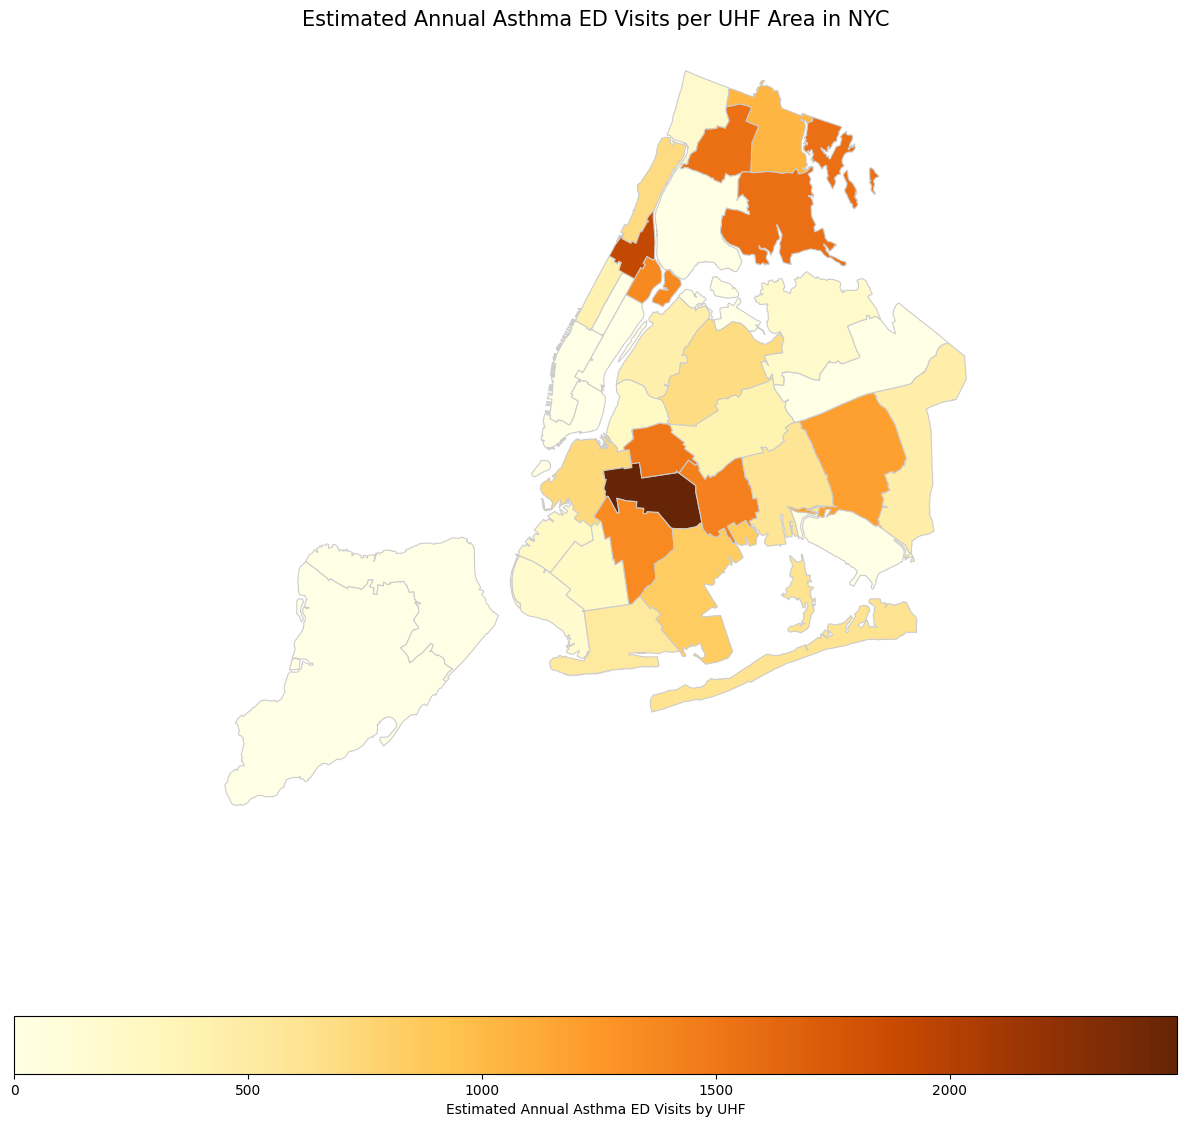

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
merged_asthma_gdf.plot(
    column='estimated_annual_ed_visits',
    cmap='YlOrBr', # A sequential colormap to show intensity of ED visits
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label': "Estimated Annual Asthma ED Visits by UHF", 'orientation': "horizontal"}
)

ax.set_title('Estimated Annual Asthma ED Visits per UHF Area in NYC', fontsize=15)
ax.set_axis_off() # Turn off the axis
plt.show()

## Summary of Asthma ED Visit Prevalence by UHF Area

Based on the choropleth map of 'Estimated Annual Asthma ED Visits per UHF Area in NYC':

**Areas with Higher Estimated Annual ED Visits (Darker Red on the map):**

*   Certain areas, particularly in **The Bronx** and parts of **Central Brooklyn** (e.g., Central Harlem, Bedford Stuyvesant - Crown Heights, Northeast Bronx, Fordham - Bronx Park), show a significantly higher number of estimated annual asthma ED visits.
*   These darker red regions indicate a greater burden of asthma-related emergency department visits in these United Health Fund (UHF) areas.

**Areas with Lower Estimated Annual ED Visits (Lighter Yellow/Orange on the map):**

*   Conversely, many areas in **Staten Island**, **Queens** (e.g., Bayside Little Neck-Fresh Meadows), and parts of **Manhattan** (e.g., Lower Manhattan, Greenwich Village-Soho) appear in lighter shades, indicating lower estimated annual asthma ED visits.
*   These regions have a comparatively lower number of asthma-related emergency department visits.

**Overall Observation:**

The map clearly illustrates geographic disparities in asthma ED visit rates across NYC, with certain boroughs and neighborhoods experiencing a disproportionately higher number of visits. This visualization can help in identifying areas where public health interventions and resources might be most critically needed to address asthma prevalence and management.